In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2, threads_per_worker=2,dashboard_address=':8888')

client = Client(cluster)
client


Client Scheduler: tcp://127.0.0.1:43189 Dashboard: http://127.0.0.1:8888/status,Cluster Workers: 2 Cores: 4 Memory: 35.01 GB


In [2]:
## Path for modules

import sys

import numpy as np
import xarray as xr

from netCDF4 import Dataset

sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date, datetime
from xhistogram.xarray import histogram

import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [3]:
def plot_histo(chunkt):
    
    ## Dataset

    data_dirT0 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
    data_dir00 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLB002-S/1h/ACO/'

    ## All files, JAS

    # No tide
    tfilename_strain00 = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_strain10m.nc'
    tfilename_curl00   = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_curl10m.nc'

    # Tide
    tfilename_strainT0 = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_strain10m.nc'
    tfilename_curlT0   = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_curl10m.nc'

    fstrain00 = xr.open_mfdataset(tfilename_strain00,combine='by_coords',parallel=True,chunks={'time_counter':chunkt})
    strain00 = fstrain00['sostrainoverf'][:]
    navlat = fstrain00['nav_lat'][0]
    navlon = fstrain00['nav_lon'][0]

    fstrainT0 = xr.open_mfdataset(tfilename_strainT0,combine='by_coords',parallel=True,chunks={'time_counter':chunkt})
    strainT0=fstrainT0['sostrainoverf'][:]

    fcurl00 = xr.open_mfdataset(tfilename_curl00,combine='by_coords',parallel=True,chunks={'time_counter':chunkt})
    curl00=fcurl00['socurloverf'][:]

    fcurlT0   = xr.open_mfdataset(tfilename_curlT0,combine='by_coords',parallel=True,chunks={'time_counter':chunkt})
    curlT0 = fcurlT0['socurloverf'][:]

    T=2*np.pi/(1E-4) # Coriolis period

    wstrainT0 = strainT0.window
    wstrainT0.set(n=48,dim='time_counter', cutoff=2*T)
    strainT0_filt = wstrainT0.convolve()

    wstrain00 = strain00.window
    wstrain00.set(n=48,dim='time_counter', cutoff=2*T)
    strain00_filt = wstrain00.convolve()

    wcurlT0 = curlT0.window
    wcurlT0.set(n=48,dim='time_counter', cutoff=2*T)
    curlT0_filt = wcurlT0.convolve()

    wcurl00 = curl00.window
    wcurl00.set(n=48,dim='time_counter', cutoff=2*T)
    curl00_filt = wcurl00.convolve()

    box=(-31,-28,33,36)
    domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
    where=np.where(domain)

    jmin = where[0][0]
    jmax = where[0][-1]
    imin = where[1][0]
    imax = where[1][-1]

    strainT0_filtbox = strainT0_filt[:,jmin:jmax+1,imin:imax+1]
    strain00_filtbox = strain00_filt[:,jmin:jmax+1,imin:imax+1]
    curlT0_filtbox = curlT0_filt[:,jmin:jmax+1,imin:imax+1]
    curl00_filtbox = curl00_filt[:,jmin:jmax+1,imin:imax+1]

    sbins = np.arange(0.0,0.5, 0.025)
    cbins = np.arange(-0.5,0.5, 0.025)

    hist_JAS_strain00_filtbox = histogram(strain00_filtbox,bins=[sbins])
    hist_JAS_strainT0_filtbox = histogram(strainT0_filtbox,bins=[sbins])
    hist_JAS_curl00_filtbox   = histogram(curl00_filtbox,bins=[cbins])
    hist_JAS_curlT0_filtbox   = histogram(curlT0_filtbox,bins=[cbins])

    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
   
  
    # Adding histograms
    hist_JAS_strain00_filtbox.plot(ax=ax1,label='no tide',lw=3.0,color='lightseagreen')
    hist_JAS_strainT0_filtbox.plot(ax=ax1,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax1.set_xlabel('24h filtered '+'curl/f',size=16)
    ax1.set_ylabel('')
    ax1.tick_params(labelsize=15)

    hist_JAS_curl00_filtbox.plot(ax=ax2,label='no tide',lw=3.0,color='lightseagreen')
    hist_JAS_curl00_filtbox.plot(ax=ax2,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax2.set_xlabel('24h filtered '+'strain/f',size=16)
    ax2.set_ylabel('')
    ax2.tick_params(labelsize=15)
    
    # Designing legend
    plt.draw()
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center',frameon=True,shadow=True,fontsize=16,bbox_to_anchor=(0.5, 0.07, 0.5, 0.5),
               markerscale=5.0,framealpha=0.8,edgecolor='black',facecolor='white')
    

    ax1.set_xlim((-0.5,0.5))
    ax2.set_xlim((0,0.5))
    
    
    

CPU times: user 2min 31s, sys: 11.2 s, total: 2min 42s
Wall time: 26min 20s


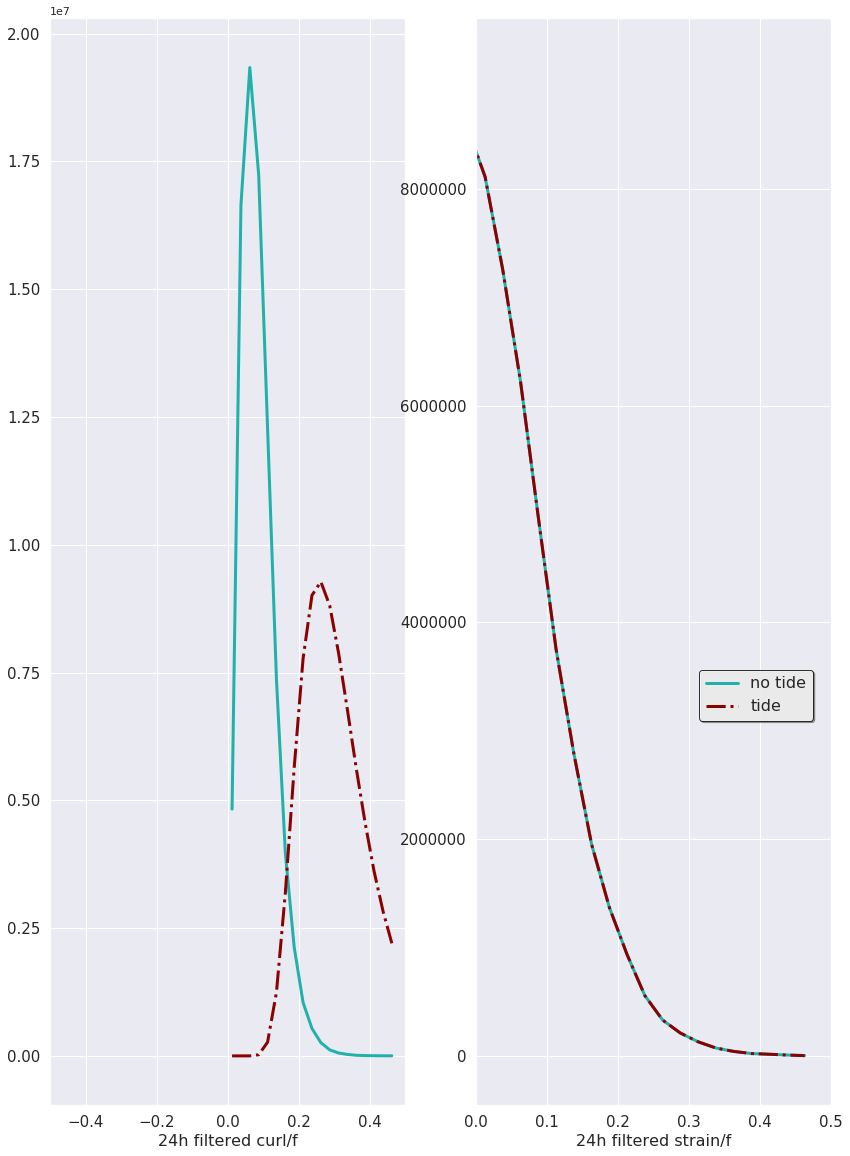

In [4]:
%%time

plot_histo(24)

CPU times: user 2min 35s, sys: 11.9 s, total: 2min 47s
Wall time: 26min 53s


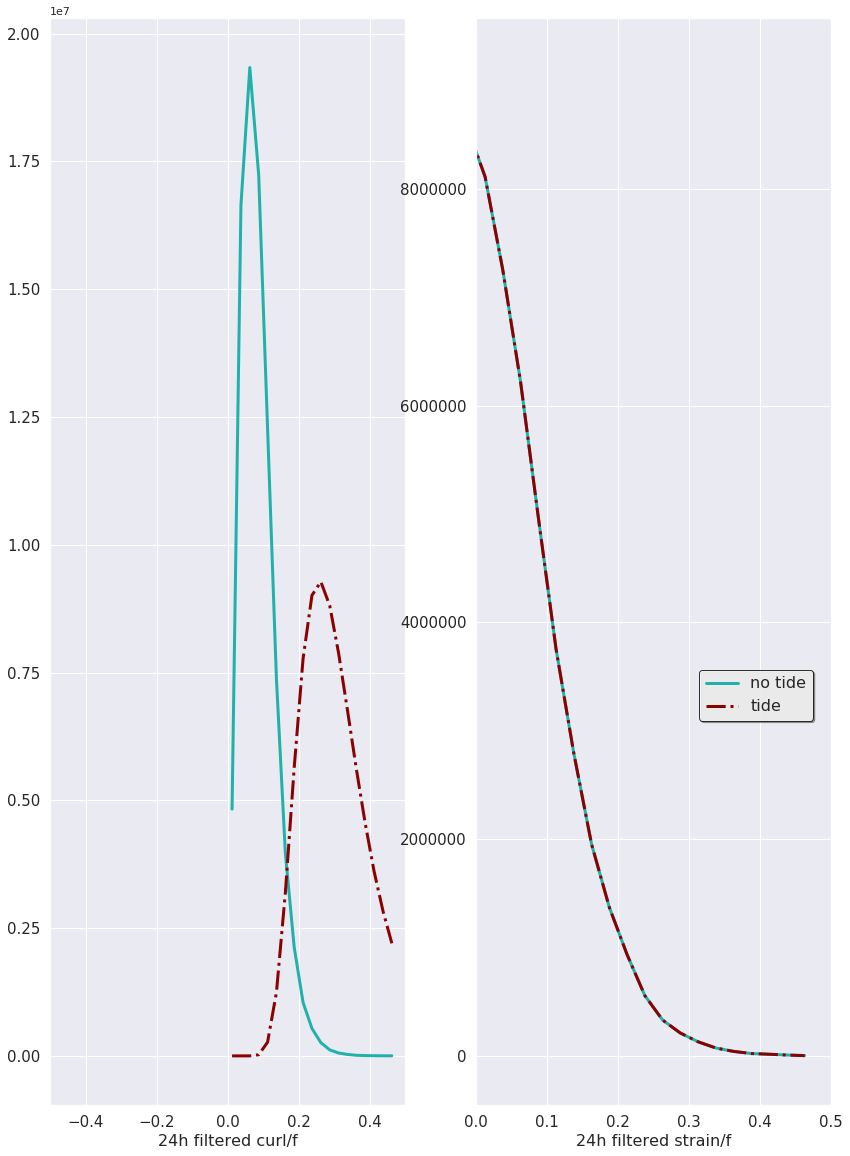

In [5]:
%%time

plot_histo(720)

In [6]:
def plot_histo_space(chunkx,chunky):
    
    ## Dataset

    data_dirT0 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
    data_dir00 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLB002-S/1h/ACO/'

    ## All files, JAS

    # No tide
    tfilename_strain00 = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_strain10m.nc'
    tfilename_curl00   = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_curl10m.nc'

    # Tide
    tfilename_strainT0 = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_strain10m.nc'
    tfilename_curlT0   = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_curl10m.nc'

    fstrain00 = xr.open_mfdataset(tfilename_strain00,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    strain00 = fstrain00['sostrainoverf'][:]
    navlat = fstrain00['nav_lat'][0]
    navlon = fstrain00['nav_lon'][0]

    fstrainT0 = xr.open_mfdataset(tfilename_strainT0,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    strainT0=fstrainT0['sostrainoverf'][:]

    fcurl00 = xr.open_mfdataset(tfilename_curl00,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    curl00=fcurl00['socurloverf'][:]

    fcurlT0   = xr.open_mfdataset(tfilename_curlT0,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    curlT0 = fcurlT0['socurloverf'][:]

    T=2*np.pi/(1E-4) # Coriolis period

    wstrainT0 = strainT0.window
    wstrainT0.set(n=48,dim='time_counter', cutoff=2*T)
    strainT0_filt = wstrainT0.convolve()

    wstrain00 = strain00.window
    wstrain00.set(n=48,dim='time_counter', cutoff=2*T)
    strain00_filt = wstrain00.convolve()

    wcurlT0 = curlT0.window
    wcurlT0.set(n=48,dim='time_counter', cutoff=2*T)
    curlT0_filt = wcurlT0.convolve()

    wcurl00 = curl00.window
    wcurl00.set(n=48,dim='time_counter', cutoff=2*T)
    curl00_filt = wcurl00.convolve()

    box=(-31,-28,33,36)
    domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
    where=np.where(domain)

    jmin = where[0][0]
    jmax = where[0][-1]
    imin = where[1][0]
    imax = where[1][-1]

    strainT0_filtbox = strainT0_filt[:,jmin:jmax+1,imin:imax+1]
    strain00_filtbox = strain00_filt[:,jmin:jmax+1,imin:imax+1]
    curlT0_filtbox = curlT0_filt[:,jmin:jmax+1,imin:imax+1]
    curl00_filtbox = curl00_filt[:,jmin:jmax+1,imin:imax+1]

    sbins = np.arange(0.0,0.5, 0.025)
    cbins = np.arange(-0.5,0.5, 0.025)

    hist_JAS_strain00_filtbox = histogram(strain00_filtbox,bins=[sbins])
    hist_JAS_strainT0_filtbox = histogram(strainT0_filtbox,bins=[sbins])
    hist_JAS_curl00_filtbox   = histogram(curl00_filtbox,bins=[cbins])
    hist_JAS_curl00_filtbox   = histogram(curlT0_filtbox,bins=[cbins])

    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
   
  
    # Adding histograms
    hist_JAS_strain00_filtbox.plot(ax=ax1,label='no tide',lw=3.0,color='lightseagreen')
    hist_JAS_strainT0_filtbox.plot(ax=ax1,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax1.set_xlabel('24h filtered '+'curl/f',size=16)
    ax1.set_ylabel('')
    ax1.tick_params(labelsize=15)

    hist_JAS_curl00_filtbox.plot(ax=ax2,label='no tide',lw=3.0,color='lightseagreen')
    hist_JAS_curl00_filtbox.plot(ax=ax2,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax2.set_xlabel('24h filtered '+'strain/f',size=16)
    ax2.set_ylabel('')
    ax2.tick_params(labelsize=15)
    
    # Designing legend
    plt.draw()
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center',frameon=True,shadow=True,fontsize=16,bbox_to_anchor=(0.5, 0.07, 0.5, 0.5),
               markerscale=5.0,framealpha=0.8,edgecolor='black',facecolor='white')
    

    ax1.set_xlim((-0.5,0.5))
    ax2.set_xlim((0,0.5))
    
    
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-d5e5622f0986f6945557002ec5953718', 1, 0, 0)": [], "('truediv-d5e5622f0986f6945557002ec5953718', 0, 0, 0)": []} state: ['waiting', 'waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-d5e5622f0986f6945557002ec5953718', 1, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-d5e5622f0986f6945557002ec5953718', 0, 0, 0)
NoneType: None


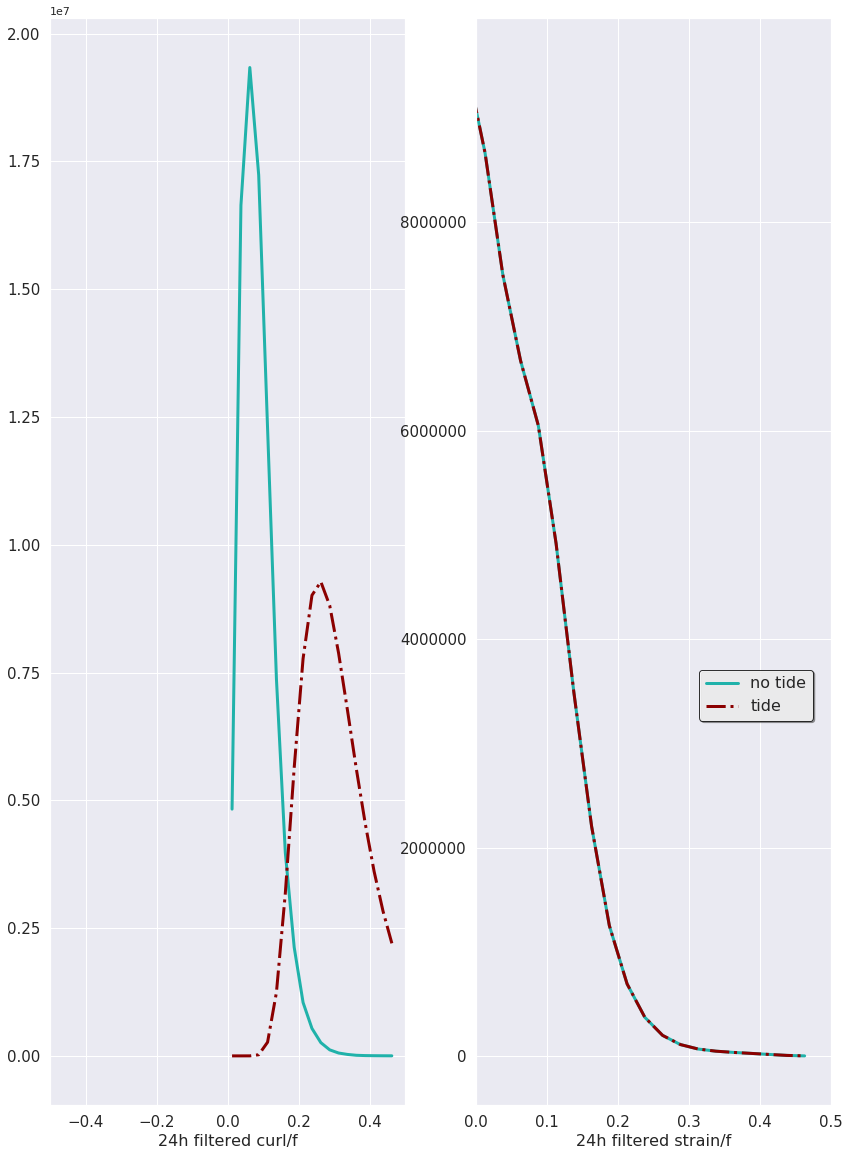

In [7]:
%time
plot_histo_space(100,100)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


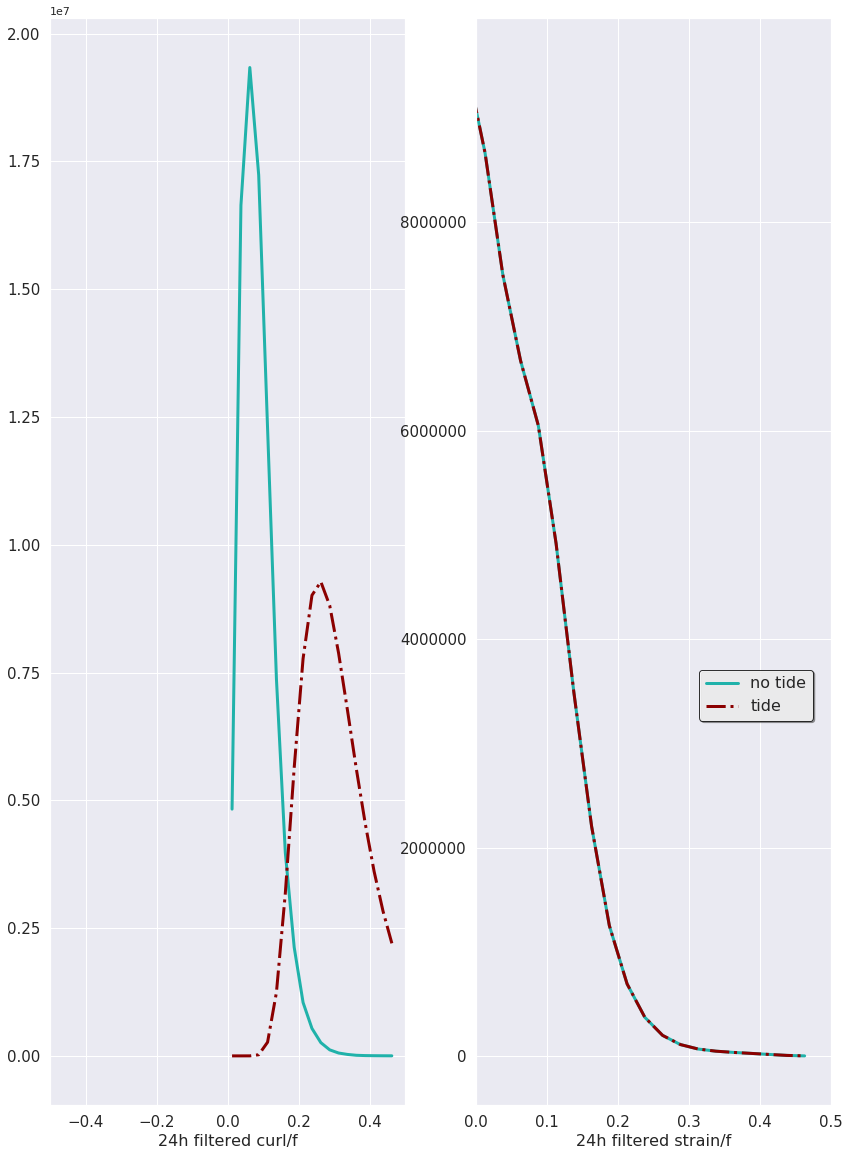

In [8]:
%time
plot_histo_space(200,200)